In [53]:
import numpy as np

from matplotlib import pyplot as plt
from matplotlib import pylab

from numba import njit

In [108]:
dt = .001
tau = .1
noise_tau = .002
w11, w22 = 1, 1
w21, w12 = 1, 1
dur = 1.5
bifurcate_time = .5
sgm = 0
threshold = 70
S = 250
R_initial = 0
G_initial = 0
eta = 0

In [115]:
@njit(parallel=True, fastmath=True)
def get_dynamic_arr(coh, a, b):

    alpha = a

    R1_arr = np.zeros(int(dur/dt))
    R2_arr = np.zeros(int(dur/dt))
    R1_arr.fill(np.NAN)
    R2_arr.fill(np.NAN)
    R1_arr[0], R2_arr[0] = R_initial, R_initial
    # R1_arr[0] = ((alpha+beta-1) + np.sqrt((1-alpha-beta)**2 + 4*S*(w11+w12-1))) / (2*(w11+w12-1))
    # R2_arr[0] = ((alpha+beta-1) + np.sqrt((1-alpha-beta)**2 + 4*S*(w22+w21-1))) / (2*(w22+w21-1))

    G1_arr = np.zeros(int(dur/dt))
    G2_arr = np.zeros(int(dur/dt))
    G1_arr[0], G2_arr[0] = G_initial, G_initial

    D1_arr = np.zeros(int(dur/dt))
    D2_arr = np.zeros(int(dur/dt))
    D1_arr[0], D2_arr[0] = 0, 0

    noise_R1 = np.zeros(int(dur/dt))
    noise_R2 = np.zeros(int(dur/dt))
    noise_G1 = np.zeros(int(dur/dt))
    noise_G2 = np.zeros(int(dur/dt))
    noise_D1 = np.zeros(int(dur/dt))
    noise_D2 = np.zeros(int(dur/dt))

    beta = 0
    V1, V2 = S*(1+coh), S*(1-coh)

    for ti in range(1, int(dur/dt)):

        if ti == bifurcate_time/dt:
            beta = b

        if ti >= bifurcate_time/dt and ti % 5 == 0:
            V1 = S*(1+coh) + np.random.randn() * eta
            V2 = S*(1-coh) + np.random.randn() * eta

        d_noiseR1 = (-noise_R1[ti-1] + np.random.randn() * np.sqrt(dt) * sgm) / noise_tau*dt
        d_noiseR2 = (-noise_R2[ti-1] + np.random.randn() * np.sqrt(dt) * sgm) / noise_tau*dt
        d_noiseG1 = (-noise_G1[ti-1] + np.random.randn() * np.sqrt(dt) * sgm) / noise_tau*dt
        d_noiseG2 = (-noise_G2[ti-1] + np.random.randn() * np.sqrt(dt) * sgm) / noise_tau*dt
        d_noiseD1 = (-noise_D1[ti-1] + np.random.randn() * np.sqrt(dt) * sgm) / noise_tau*dt
        d_noiseD2 = (-noise_D2[ti-1] + np.random.randn() * np.sqrt(dt) * sgm) / noise_tau*dt

        d_R1 = (-R1_arr[ti-1] + (alpha * R1_arr[ti-1] + V1) / (1 + G1_arr[ti-1])) * dt/tau
        d_R2 = (-R2_arr[ti-1] + (alpha * R2_arr[ti-1] + V2) / (1 + G2_arr[ti-1])) * dt/tau
        d_G1 = (-G1_arr[ti-1] + w11*R1_arr[ti-1] + w12*R2_arr[ti-1] - D1_arr[ti-1]) * dt/tau
        d_G2 = (-G2_arr[ti-1] + w21*R1_arr[ti-1] + w22*R2_arr[ti-1] - D2_arr[ti-1]) * dt/tau
        d_D1 = (-D1_arr[ti-1] + beta + .5*R1_arr[ti-1]) *dt/tau
        d_D2 = (-D2_arr[ti-1] + beta + .5*R2_arr[ti-1]) *dt/tau

        noise_R1[ti] = noise_R1[ti-1] + d_noiseR1
        noise_R2[ti] = noise_R2[ti-1] + d_noiseR2
        noise_G1[ti] = noise_G1[ti-1] + d_noiseG1
        noise_G2[ti] = noise_G2[ti-1] + d_noiseG2
        noise_D1[ti] = noise_D1[ti-1] + d_noiseD1
        noise_D2[ti] = noise_D2[ti-1] + d_noiseD2

        R1_arr[ti] = max(R1_arr[ti-1] + d_R1 + noise_R1[ti], 0)
        R2_arr[ti] = max(R2_arr[ti-1] + d_R2 + noise_R2[ti], 0)
        G1_arr[ti] = max(G1_arr[ti-1] + d_G1 + noise_G1[ti], 0)
        G2_arr[ti] = max(G2_arr[ti-1] + d_G2 + noise_G2[ti], 0)
        D1_arr[ti] = max(D1_arr[ti-1] + d_D1 + noise_D1[ti], 0)
        D2_arr[ti] = max(D2_arr[ti-1] + d_D2 + noise_D2[ti], 0)

        if R1_arr[ti] > threshold and ti >= bifurcate_time/dt:
            R1_arr[ti] = np.NAN
            break
        elif R2_arr[ti] > threshold and ti >= bifurcate_time/dt:
            R2_arr[ti] = np.NAN
            break

    return R1_arr, R2_arr

In [116]:
def draw_dynamic(c, a, b, color):
    R1_arr, R2_arr = get_dynamic_arr(c, a, b)

    plt.plot(R1_arr, linewidth=1.5, color=color, label='coherence =%.3f' % c)
    plt.plot(R2_arr, linestyle='--', color=color, linewidth=1)

    plt.xlabel("RT (ms)")
    plt.ylabel("Activity (Hz)")
    plt.ylim(top=85, bottom=0)
    plt.title("Single Trial Dynamic")

    plt.tight_layout()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


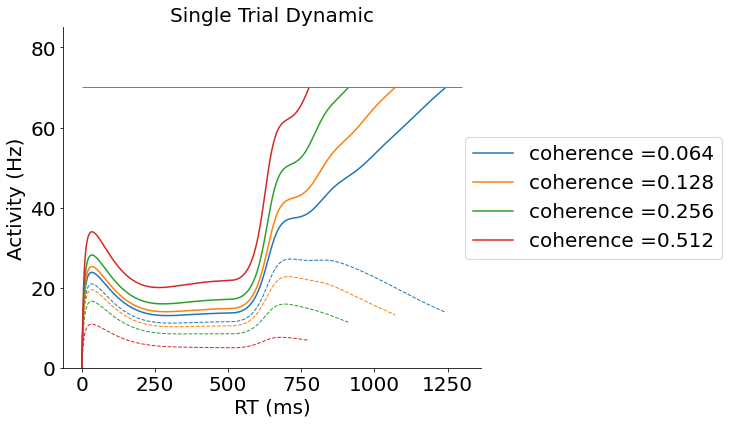

In [118]:
draw_dynamic(.064, 0, 50, 'C0')
draw_dynamic(.128, 0, 50, 'C1')
draw_dynamic(.256, 0, 50, 'C2')
draw_dynamic(.512, 0, 50, 'C3')

plt.hlines(y=70, xmin=0, xmax=1300, color='slategrey', linewidth=1)

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.legend()

plt.legend(loc='center right', bbox_to_anchor=(1.6, .5), fancybox=True)

font_size = 20
ax.annotate('threshold', (1750, 71), color='slategrey', fontsize=font_size)
params = {
    'figure.figsize': (7, 6),
     'legend.fontsize': font_size,
     'axes.labelsize': font_size,
     'axes.titlesize': font_size,
     'xtick.labelsize': font_size,
     'ytick.labelsize': font_size
}
pylab.rcParams.update(params)

plt.savefig('Single Dynamic(25, 30).tiff', format='tiff', bbox_inches='tight')
plt.savefig('Single Dynamic(25, 30).eps', format='eps', bbox_inches='tight')